In [81]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import pyarrow 

In [82]:
# Load the data
df = pd.read_parquet('yellow_tripdata_2023-01.parquet')

In [83]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,2023-01-01 00:32:10,2023-01-01 00:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00
1,2,2023-01-01 00:55:08,2023-01-01 01:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00
2,2,2023-01-01 00:25:04,2023-01-01 00:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00
3,1,2023-01-01 00:03:48,2023-01-01 00:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25
4,2,2023-01-01 00:10:29,2023-01-01 00:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00


In [84]:
df.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')

In [85]:
df.describe

<bound method NDFrame.describe of          VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0               2  2023-01-01 00:32:10   2023-01-01 00:40:36              1.0   
1               2  2023-01-01 00:55:08   2023-01-01 01:01:27              1.0   
2               2  2023-01-01 00:25:04   2023-01-01 00:37:49              1.0   
3               1  2023-01-01 00:03:48   2023-01-01 00:13:25              0.0   
4               2  2023-01-01 00:10:29   2023-01-01 00:21:19              1.0   
...           ...                  ...                   ...              ...   
3066761         2  2023-01-31 23:58:34   2023-02-01 00:12:33              NaN   
3066762         2  2023-01-31 23:31:09   2023-01-31 23:50:36              NaN   
3066763         2  2023-01-31 23:01:05   2023-01-31 23:25:36              NaN   
3066764         2  2023-01-31 23:40:00   2023-01-31 23:53:00              NaN   
3066765         2  2023-01-31 23:07:32   2023-01-31 23:21:56              N

In [86]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

In [87]:
# convert to data frame
df.tpep_pickup_datetime = pd.to_datetime(df.tpep_pickup_datetime)
df.tpep_dropoff_datetime = pd.to_datetime(df.tpep_dropoff_datetime)

In [88]:
df['duration'] = df.tpep_dropoff_datetime - df.tpep_pickup_datetime

In [89]:
df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

In [90]:
# compute the std
df.duration.std()

42.594351241920904

C:\Users\ADMIN\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='duration', ylabel='Density'>

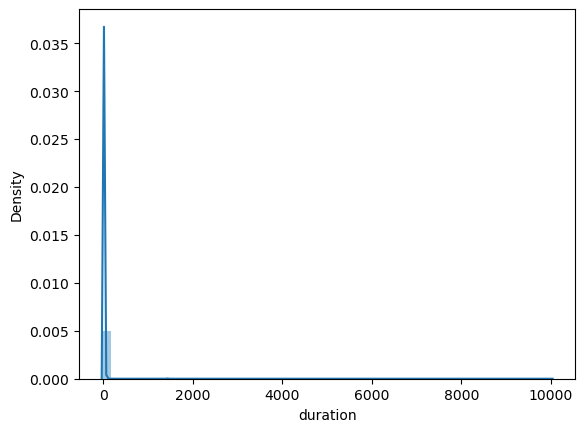

In [91]:
sns.distplot(df.duration)

In [92]:
df_filtered = df[(df.duration >=1) & (df.duration <=60)]

In [93]:
fraction_left = len(df_filtered) / len(df)

print("Fraction of records left after dropping outliers:", fraction_left)

Fraction of records left after dropping outliers: 0.9812202822125979


In [94]:
df = df[(df.duration >=1) & (df.duration <=60)]

In [95]:
categorical = ['PULocationID', 'DOLocationID']
df[categorical] = df[categorical]. astype(str)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_7044\651329356.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[categorical] = df[categorical]. astype(str)


In [96]:
from sklearn.feature_extraction import DictVectorizer

In [97]:
train_dicts = df[categorical].to_dict(orient='records')

In [98]:
# Initialize and fit the dictionary vectorizer
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

In [99]:
num_col =X_train.shape[1]

In [100]:
print("Dimensionality of the feature matrix:", num_col)

Dimensionality of the feature matrix: 515


In [101]:
target = 'duration'
y_train = df[target].values

In [102]:
y_train

array([ 8.43333333,  6.31666667, 12.75      , ..., 24.51666667,
       13.        , 14.4       ])

In [103]:
from sklearn.linear_model import LinearRegression

In [104]:
lr= LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [105]:
y_pred = lr.predict(X_train)

C:\Users\ADMIN\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\ADMIN\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


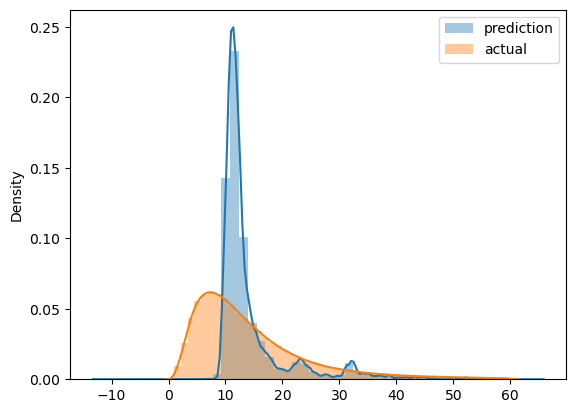

In [106]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [107]:
from sklearn.metrics import mean_squared_error

In [108]:
# Calculate the RMSE
rmse_train = mean_squared_error(y_train, y_pred, squared=False)

In [109]:
rmse_train 

7.6492624470603

In [110]:
import pandas as pd

def read_data(filename):
    # Read the Parquet file into a DataFrame
    df = pd.read_parquet(filename)
    
    # Convert pickup and dropoff datetime columns to datetime objects
    df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
    
    # Calculate the duration of each trip in minutes
    df['duration'] = (df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']).apply(lambda td: td.total_seconds() / 60)
    
    # Filter the DataFrame to include only trips with duration between 1 and 60 minutes
    df = df[(df['duration'] >= 1) & (df['duration'] <= 60)]
    
    # Define the categorical columns
    categorical = ['PULocationID', 'DOLocationID']
    
    # Convert the categorical columns to string type
    df[categorical] = df[categorical].fillna(-1).astype('int').astype(str)
    
    # Return the processed DataFrame
    return df

# Now call the function
df_val = read_data('yellow_tripdata_2023-02.parquet')

    

In [111]:
df_val.dtypes

VendorID                          int32
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                     object
DOLocationID                     object
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
Airport_fee                     float64
duration                        float64
dtype: object

In [112]:
val_dicts = df_val[categorical].to_dict(orient='records')

In [113]:
X_val = dv.transform(val_dicts)

In [114]:
y_pred = lr.predict(X_val)

In [115]:

y_val = df_val.duration.values

In [116]:
y_val

array([ 1.68333333, 32.08333333, 13.3       , ..., 14.        ,
        7.        ,  9.8       ])

In [117]:
rmse_val = mean_squared_error(y_val, y_pred, squared=False)

In [118]:
rmse_val

7.811811277666989